<a href="https://colab.research.google.com/github/arquansa/PSTB-exercises/blob/main/Week06/Day4/DC4/W6D4DC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Understanding PyTorch#
PyTorch is an open-source machine learning framework based on the Torch library, used for applications such as computer vision and natural language processing. It’s known for its flexibility and ease of use, making it popular for both research and production.

Key PyTorch Functions You’ll Use:

torch.nn.Module: Base class for all neural network modules. You’ll use this to define your LSTM model.
torch.nn.LSTM: Implements a Long Short-Term Memory (LSTM) network.
torch.nn.Linear: Applies a linear transformation to the incoming data (i.e., a fully connected layer).
torch.nn.Dropout: Applies dropout regularization to prevent overfitting.
torch.optim.Adam: Implements the Adam optimization algorithm.
torch.nn.MSELoss: Implements the Mean Squared Error loss function.
torch.utils.data.Dataset: An abstract class representing a dataset.
torch.utils.data.DataLoader: Combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset.
torch.Tensor: A multi-dimensional matrix containing elements of a single data type.
torch.save and torch.load: used to save and load trained models.
For further understanding on how to use Pytorch functions, you can watch this video and this one too, good luck !


---



#Import libraries#

In [ ]:
import pandas as p#
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#Load and preprocess dataset#
- Afficher 5 premières lignes du dataset
- Afficher 5 dernières lignes du dataset

In [ ]:
df = pd.read_csv('stock_market_dataset.csv')

In [ ]:
display(df.head())

,unix,date,symbol,open,high,low,close,Volume XRP,Volume USDT
0,1.640560e+12,12-27-2021,XRP-USDT,0.9200,0.9237,0.9200,0.9226,2384512.0,2.198450e+06
1,1.640480e+12,12-26-2021,XRP-USDT,0.9252,0.9334,0.9052,0.9200,163438501.0,1.499400e+08
2,1.640390e+12,12-25-2021,XRP-USDT,0.9114,0.9350,0.8981,0.9252,250074945.0,2.302303e+08
3,1.640300e+12,12-24-2021,XRP-USDT,0.9941,0.9966,0.8964,0.9115,567234092.0,5.377035e+08
4,1.640220e+12,12-23-2021,XRP-USDT,0.9538,1.0167,0.9372,0.9941,479436230.0,4.729372e+08


In [ ]:
display(df.tail())

,unix,date,symbol,open,high,low,close,Volume XRP,Volume USDT
1329,1.525740e+12,5-8-2018,XRP-USDT,0.82490,0.84802,0.79200,0.80667,12971303.18,10571844.13
1330,1.525650e+12,5-7-2018,XRP-USDT,0.86482,0.86886,0.80000,0.82490,17303486.40,14192279.73
1331,1.525560e+12,5-6-2018,XRP-USDT,0.90280,0.91800,0.83774,0.86483,16002035.80,13997141.56
1332,1.525480e+12,5-5-2018,XRP-USDT,0.88980,0.93500,0.88800,0.90280,16816165.30,15282000.08
1333,1.525390e+12,5-4-2018,XRP-USDT,0.50000,1.50000,0.50000,0.88990,20890213.82,18946724.69


The dataset comprises 1334 lines x 10 columns

*   Target is 'close' (closing price)




In [ ]:

df.columns

Index(['unix', 'date', 'symbol', 'open', 'high', 'low', 'close', 'Volume XRP',
       'Volume USDT'],
      dtype='object')

Typical pip install commands:

In [ ]:
pip install numpy pandas scikit-learn matplotlib tensorflow

*Convertir en valeurs numériques (si besoin) et gérer les valeurs manquantes*

In [ ]:
data = df[['close']]
data = data.dropna()  # Supprimer les lignes avec valeurs manquantes
data = data.astype('float32')  # Convertir en float (optionnel selon dataset)

*Normaliser les données (échelle entre 0 et 1) avec MinMaxScaler*

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


*Créer des séquences temporelles (par exemple, séquences de 60 jours) pour LSTM*
LSTM attend des séquences de données pour apprendre les dépendances dans le temps.

In [ ]:
import numpy as np

def create_sequences(data, seq_length=60):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])  # séquence de 60 jours
        y.append(data[i, 0])               # valeur cible (jour suivant)
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, seq_length=60)

# Reshape pour LSTM [samples, time_steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


*Prepare the Dataset for Training*

*Split the dataset into training, validation, and testing sets*

In [ ]:
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


*Create the Custom Dataset Class*

In [ ]:
from torch.utils.data import Dataset

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # shape: [samples, seq_len, 1]
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

*Use DataLoader to create iterable datasets for training and evaluation*

In [ ]:
import torch
from torch.utils.data import DataLoader

dataset = StockDataset(X, y)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Example: Iterate through batches
for batch_X, batch_y in loader:
    print(batch_X.shape)  # [32, 60, 1]
    print(batch_y.shape)  # [32]
    break

torch.Size([32, 60, 1])
torch.Size([32])


#Define the LSTM Model#

In [ ]:
import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # GRU layer
        self.gru = nn.GRU(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True,
                          dropout=dropout)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer (Dense)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: [batch, sequence_length, input_size]
        out, _ = self.gru(x)  # out: [batch, seq_len, hidden_size]

        # Use only the last time step's output
        out = out[:, -1, :]   # [batch, hidden_size]

        out = self.dropout(out)
        out = self.fc(out)    # [batch, 1]
        return out

*GRU-Based Model in PyTorch*

*Train the Model*

*Full Training Script (PyTorch, GRU for Time Series)*

In [ ]:
import torch.optim as optim

# Instantiate the model
model = GRUModel()

# Use Mean Squared Error loss
criterion = nn.MSELoss()

# Use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

*Training & Validation Loops*

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        train_loss = 0.0
        model.train()

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_X.size(0)

        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X).squeeze()
                loss = criterion(outputs, batch_y)
                val_loss += loss.item() * batch_X.size(0)

        val_loss /= len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")


# Train the Model #

In [ ]:
from torch.utils.data import random_split

# Split the dataset into training, validation, and testing sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders for training, validation, and testing sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


# Define number of epochs
epochs = 20

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device)

Epoch 1/20 | Train Loss: 0.001637 | Val Loss: 0.001151
Epoch 2/20 | Train Loss: 0.001245 | Val Loss: 0.000917
Epoch 3/20 | Train Loss: 0.001368 | Val Loss: 0.000989
Epoch 4/20 | Train Loss: 0.001426 | Val Loss: 0.000993
Epoch 5/20 | Train Loss: 0.001166 | Val Loss: 0.000885
Epoch 6/20 | Train Loss: 0.001520 | Val Loss: 0.001022
Epoch 7/20 | Train Loss: 0.001325 | Val Loss: 0.000973
Epoch 8/20 | Train Loss: 0.001416 | Val Loss: 0.001533
Epoch 9/20 | Train Loss: 0.001512 | Val Loss: 0.000974
Epoch 10/20 | Train Loss: 0.001234 | Val Loss: 0.000868
Epoch 11/20 | Train Loss: 0.001593 | Val Loss: 0.001015
Epoch 12/20 | Train Loss: 0.001296 | Val Loss: 0.001058
Epoch 13/20 | Train Loss: 0.001131 | Val Loss: 0.000941
Epoch 14/20 | Train Loss: 0.001242 | Val Loss: 0.000834
Epoch 15/20 | Train Loss: 0.001221 | Val Loss: 0.000818
Epoch 16/20 | Train Loss: 0.001268 | Val Loss: 0.000878
Epoch 17/20 | Train Loss: 0.001333 | Val Loss: 0.000948
Epoch 18/20 | Train Loss: 0.001256 | Val Loss: 0.001314
E

*Evaluate the Model with R² Score on Test Set
Import Required Metric*

In [ ]:
from sklearn.metrics import r2_score


*Evaluate on Test Data*

In [ ]:
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X).squeeze().cpu().numpy()
        targets = batch_y.numpy()

        predictions.extend(outputs)
        actuals.extend(targets)

# Calculate R² score
r2 = r2_score(actuals, predictions)
print(f"R² Score on Test Set: {r2:.4f}")


R² Score on Test Set: 0.9777


*Save the MinMaxScaler for Future Use
 Save Scaler with joblib or pickle*

In [ ]:
import joblib

# Save the scaler to a file
joblib.dump(scaler, 'scaler.save')
print("Scaler saved to scaler.save")


Scaler saved to scaler.save


*Plot Predictions vs. Actual Values (on Test Set)*

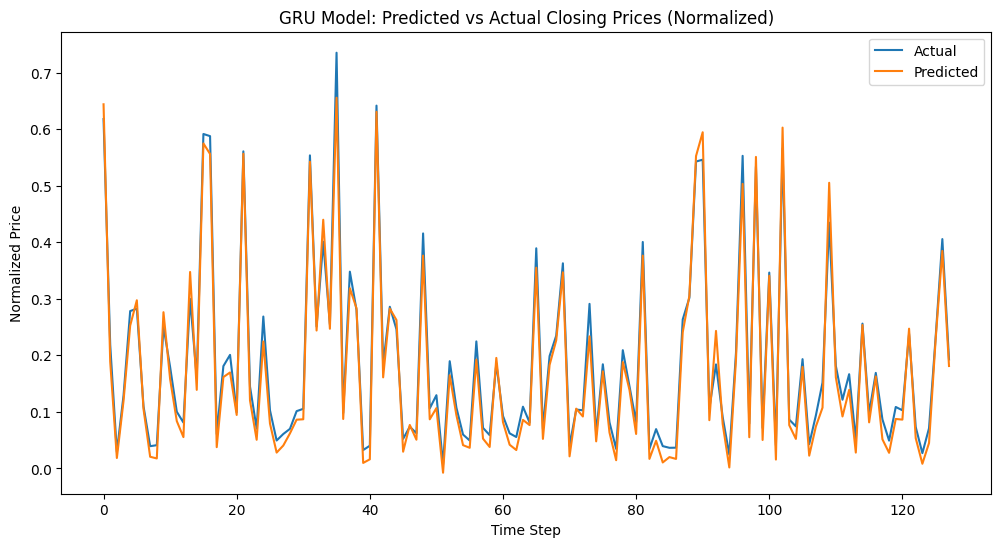

In [ ]:
import matplotlib.pyplot as plt

# Plot test predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('GRU Model: Predicted vs Actual Closing Prices (Normalized)')
plt.xlabel('Time Step')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()


#**CONCLUSION**#
This plot shows a strong alignment between predicted and actual closing prices.

R² (Coefficient of Determination) = 0.9777.

97.77% of the variance in the actual closing prices is explained by the GRU model’s predictions.

The model has captured the overall trend and seasonality in the data, minor deviations being observed during periods of high volatility - generally speaking,  the model demonstrates robust generalization performance.